## **Description**

This notebook was created in Google Colab environment for comparing the performance of classification algorithms over an artificial datase. Each block written bellow has their own comments explaining the main ideas and objectives of the code. The notebook may be divided into 2 parts, for better understanding. The first one is the exploratory analysis phase and the second one is the modeling phase.

Considering this notebook would be presented for a non-technical audience, its construction was designed to be in a step-by-step form, with explanations regarding each of the phases.

In [0]:
'''Import of the used libraries for both the exploratory phase and modeling phase'''
from google.colab import files
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from itertools import combinations, combinations_with_replacement
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import seaborn as sns
from sklearn.dummy import DummyClassifier
import missingno as msno 
import random
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
'''Reading txt file and converting it into pandas dataframe'''
uploaded = files.upload()
df = pd.read_csv(io.StringIO(uploaded["df_points.txt"].decode("utf-8")), sep='\t', index_col=0)

'''Checking the size of the dataset'''
print('\n' + str(df.shape))

Saving df_points.txt to df_points (1).txt

(10000, 4)


## **Exploratory Analisys**

On this phase we try to identify possible problems and behaviors of the dataset, which could cause problems on the modeling phase. It's also important to note that now it's time for checking the statistics of the dataset, if it contains unbalanced distribution of the labels, if its features are correlated. Finally, it's possible to manipulate the original features, generating new ones that may be more significant for the prediction.

There are [0 0 0 0] missing numbers on the columns of the dataset

 Statistics for the feature x:
Max value:  499.87245319639527    499.67081364231353
Min value:  -499.80234786888605    -499.459276603036
Mean value:  -1.7380629353523473    3.4109825300639827


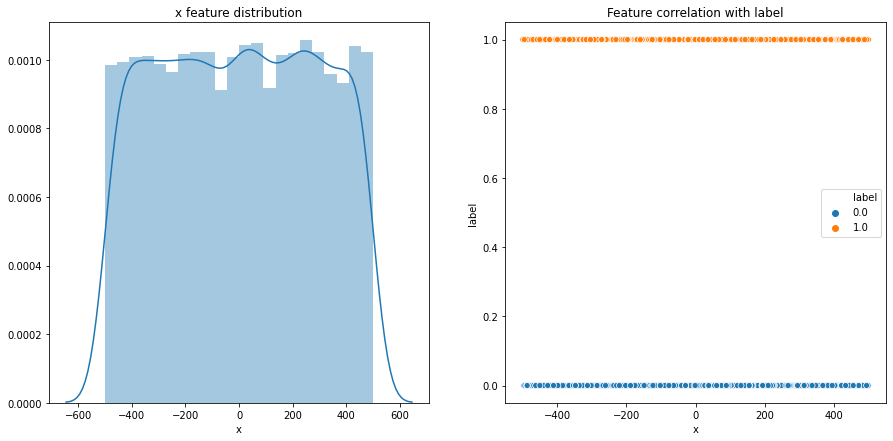


 Statistics for the feature y:
Max value:  499.745915919654    499.75241829102
Min value:  -499.83431063541593    -499.8991340174146
Mean value:  -6.813405196819263    0.556072893616281


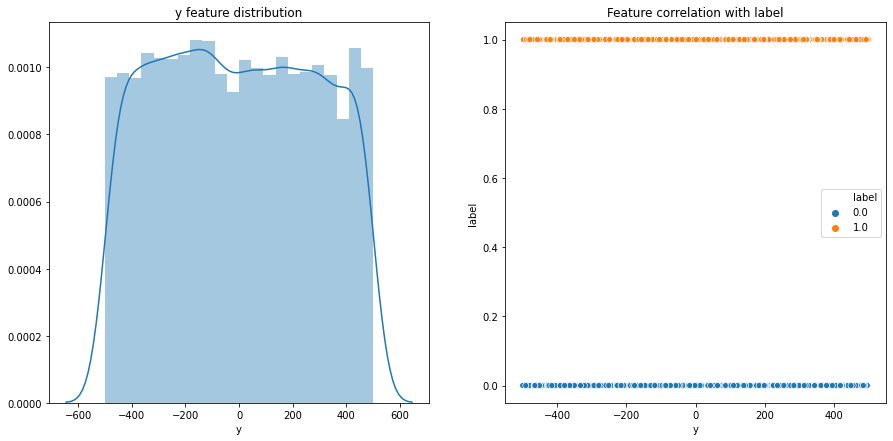


 Statistics for the feature z:
Max value:  499.8723286553282    499.8561403089344
Min value:  -499.95257090512223    -499.74295064476985
Mean value:  2.5708171321136755    -7.7175080159508544


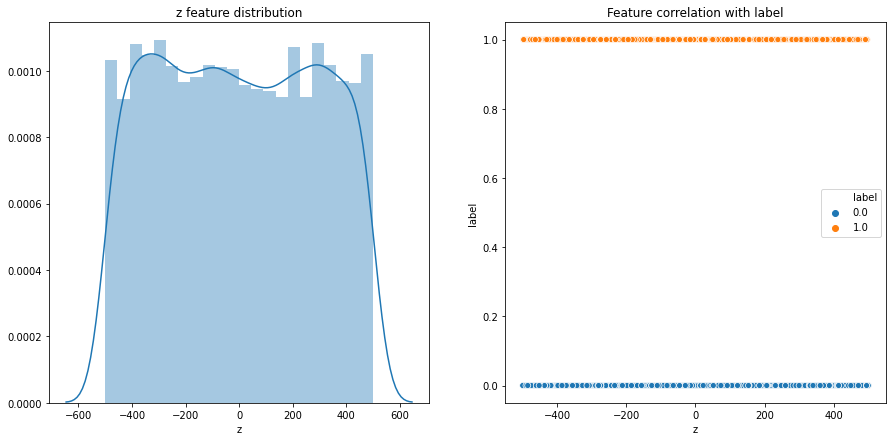

In [0]:
'''Checking for missing values, if they exist'''
missing_values = df.isnull().sum().values
print("There are {} missing numbers on the columns of the dataset".format(missing_values))

'''Checking for relations between each variable and the label'''
for column in df.columns[:-1]:
  start = random.randrange(len(df))
  df_ = df[start:start+1000]
  print('\n', 'Statistics for the feature ' + column + ':')
  print('Max value: ', df[df.label==0][column].max(), '  ', df[df.label==1][column].max())
  print('Min value: ', df[df.label==0][column].min(), '  ', df[df.label==1][column].min())
  print('Mean value: ', df[df.label==0][column].mean(), '  ', df[df.label==1][column].mean())
  fig, ax =plt.subplots(1,2,figsize=(15,7))
  sns.distplot(df[column], ax=ax[0]).set_title(column+' feature distribution')
  sns.scatterplot(x=column, y="label", hue="label", data=df_, ax=ax[1]).set_title('Feature correlation with label')
  plt.show()


 50.27 % of the records correspond to class 1 in the dataset

 The table shows the correlation between features, with values close to 0 (darker color) being the smallest correlation
          x         y         z
x  1.000000 -0.007873  0.000331
y -0.007873  1.000000  0.007636
z  0.000331  0.007636  1.000000


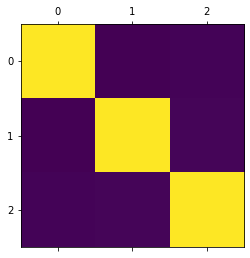

In [0]:
'''Checking for unbalanced distribution of the labels'''
print('\n', df['label'].sum()/df['label'].count()*100, '% of the records correspond to class 1 in the dataset')

'''Checking for correlations between the original features'''
print('\n', 'The table shows the correlation between features, with values close to 0 (darker color) being the smallest correlation')
print(df[df.columns[:-1]].corr())
plt.matshow(df[df.columns[:-1]].corr())

## **Comments**
From analising the figures and informations above it's possible to point some characteristics of the features:

*   The two classes of labels present in the dataset are balanced, which means we can use accuracy as a metric for the modeling phase. If it was unbalanced another approach would be necessary, for example, considering the f1 score (false positive and false negative relations)
*   All the original features present a quasi-uniform distribution, with no clear evidence for direct relation with the labels they represent or between themselves





## **First modeling**

With a clearer understanding of the dataset, it's time for predictive modeling of the dataset for setting standards and discussing if there's possible to improve results and what are the possibilities for doing so. 

Initially, using only the original features, it was proposed the use of different logistic regressors available through the ScikitLearn package. It is important to try different regressors for identifying the best approaches for the specific problem we are dealing with.

In [0]:
'''First step for modeling is to separate the dataset into training and testing parts. Since we have a rather small dataset,
we will set the proportion to 80% for training and 20% for testing. We won't use validation sets on this modeling'''
X_train, X_test, y_train, y_test = train_test_split(df[['x', 'y', 'z']], df['label'], test_size=.2, random_state=42)

In [0]:
'''One other step that usually improves the performance of classification algorithms is to scale the datasets. This time we'll use
the MinMaxScaler for doing so. Fitting it to the training set only guarantees that no information is being leaked from the test set.'''
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
'''As a comparison we will use a set of different regressors based on clustering, suport vector machines, decision trees and neural networks'''
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import tensorflow as tf


classifiers = [
                LogisticRegression(solver='liblinear', random_state=0),
                KNeighborsClassifier(20),
                SVC(kernel="linear", C=0.025),
                SVC(gamma=2, C=1),
                DecisionTreeClassifier(max_depth=5),
                RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                MLPClassifier(alpha=1, max_iter=1000),
                AdaBoostClassifier(),
                GaussianNB(),
                QuadraticDiscriminantAnalysis()
                ]

'''One last approach is using the Tensorflow library for building a neural network from scratch. For the classification case,
we need to use the binary crossentropy, while the optimizer is a hyperparameter to be tuned. For this dataset, the Adam optimizer
showed better results'''
nn = tf.keras.Sequential([
                          tf.keras.layers.Dense(512, activation=tf.keras.layers.ReLU(), input_shape=(X_train.shape[1],)),
                          tf.keras.layers.Dense(128),
                          tf.keras.layers.Dense(32),
                          tf.keras.layers.Dropout(0.3),
                          tf.keras.layers.Dense(1, activation='sigmoid')
                          ])
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
original_scores = []
for clf in classifiers:
  clf.fit(X_train, y_train)
  score = clf.score(X_test, y_test)
  original_scores.append(score)
  print(str(clf).split('(')[0] + ' model gives a score of ', score)

nn.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=50, batch_size=128, verbose=0)
original_scores.append(nn.evaluate(X_test, y_test, batch_size=128)[1])
print('nn model gives a score of ', original_scores[-1])

LogisticRegression model gives a score of  0.567
KNeighborsClassifier model gives a score of  0.7735
SVC model gives a score of  0.4995
SVC model gives a score of  0.7565
DecisionTreeClassifier model gives a score of  0.5005
RandomForestClassifier model gives a score of  0.6155
MLPClassifier model gives a score of  0.5875
AdaBoostClassifier model gives a score of  0.536
GaussianNB model gives a score of  0.5675
QuadraticDiscriminantAnalysis model gives a score of  0.511
2000/2000 [==============================] - 0s 14us/sample - loss: 0.5436 - accuracy: 0.7505
nn model gives a score of  0.7505


## **Final modeling**

From the original features it's possible to create some aditional ones using mathematical manipulations on them. It is possible to do this by hand, using the set of combinations between the original features but ScikitLearn offers a library that can build polynomial relations between features automatically. Again, it's necessary to apply these transformations to both the training and testing sets. 

In [0]:
'''The choice of the degree of the polynomial is another hyperparamenter that needs to be adjusted to the specific problem 
we are dealing with. This time it was noted that the degree of 3 was the one that showed to be significant'''
poly = PolynomialFeatures(3, interaction_only=True)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
print(X_train.shape)

(8000, 8)


In [0]:
classifiers = [
                LogisticRegression(solver='liblinear', random_state=0),
                KNeighborsClassifier(20),
                SVC(kernel="linear", C=0.025),
                SVC(gamma=2, C=1),
                DecisionTreeClassifier(max_depth=5),
                RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                MLPClassifier(alpha=1, max_iter=1000),
                AdaBoostClassifier(),
                GaussianNB(),
                QuadraticDiscriminantAnalysis()
                ]

nn = tf.keras.Sequential([
                          tf.keras.layers.Dense(512, activation=tf.keras.layers.ReLU(), input_shape=(X_train.shape[1],)),
                          tf.keras.layers.Dense(128),
                          tf.keras.layers.Dense(32),
                          tf.keras.layers.Dropout(0.3),
                          tf.keras.layers.Dense(1, activation='sigmoid')
                          ])
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

final_scores = []
for clf in classifiers:
  clf.fit(X_train, y_train)
  score = clf.score(X_test, y_test)
  final_scores.append(score)
  print(str(clf).split('(')[0] + ' model gives a score of ', score)

nn.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=50, batch_size=128, verbose=0)
final_scores.append(nn.evaluate(X_test, y_test, batch_size=128)[1])
print('nn model gives a score of ', final_scores[-1])

LogisticRegression model gives a score of  0.7235
KNeighborsClassifier model gives a score of  0.7745
SVC model gives a score of  0.498
SVC model gives a score of  0.757
DecisionTreeClassifier model gives a score of  0.652
RandomForestClassifier model gives a score of  0.711
MLPClassifier model gives a score of  0.7295
AdaBoostClassifier model gives a score of  0.6735
GaussianNB model gives a score of  0.5255
QuadraticDiscriminantAnalysis model gives a score of  0.5005
2000/2000 [==============================] - 0s 14us/sample - loss: 0.5506 - accuracy: 0.7415
nn model gives a score of  0.7415


### **Comparison and final comments**

From the results it is possible to observe some interesting points. For the Logistic Regressor, there was a significant improvement on the results from the original features to the final ones. This can be explained by the linear relation the model applies to the features in order to generate a mathematical relation between them. So, the generation of more features was capable of explaining more the information contained in the dataset. The same results can be observed on decision tree based models. The explanation is similar, since these models use a progressive division of each feature for deciding the label they should receive. For the other models the results obtained on the final approach were similar since, depending on the models, they already use some sort of internal compression for the extraction of information from the data. For the Neural Network this condition is clearer, since this kind of model is capable of generating several combinations between the input features on its development. The results attained were considered satisfactory since little information were given about the dataset and the time was limited for the solution. Other approaches could be used on an attempt to improve the results such as increasing the number of features generated and the adjustment of the hyperparameters for each model built. All these approaches were conducted on the execution, although it was not performed with the depth necessary.



In [0]:
print(f"{'Classifier':<30}{'Original Score':<20}{'Final Score':>10}")
for i in range(len(classifiers)):
  print(f"{str(classifiers[i]).split('(')[0]:<30}{original_scores[i]:<20}{final_scores[i]:>10}")
print(f"{'Neural Network':<30}{str(original_scores[-1])[0:5]:<20}{str(final_scores[-1])[0:5]:>10}")

Classifier                    Original Score      Final Score
LogisticRegression            0.567                   0.7235
KNeighborsClassifier          0.7735                  0.7745
SVC                           0.4995                   0.498
SVC                           0.7565                   0.757
DecisionTreeClassifier        0.5005                   0.652
RandomForestClassifier        0.6155                   0.711
MLPClassifier                 0.5875                  0.7295
AdaBoostClassifier            0.536                   0.6735
GaussianNB                    0.5675                  0.5255
QuadraticDiscriminantAnalysis 0.511                   0.5005
Neural Network                0.750                    0.741
